<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

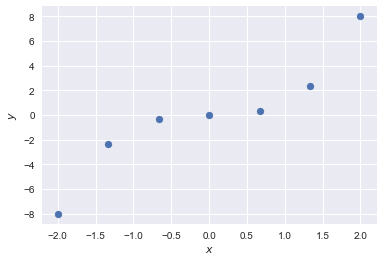

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

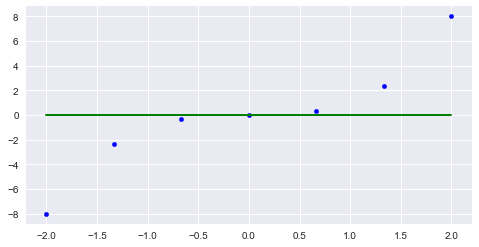

In [3]:
# Ваш код здесь
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth=0.1)
tree.fit(X.reshape(len(X), 1), y)
pred = tree.predict(np.linspace(-2, 2, 100).reshape(100, 1))

plt.figure(figsize=(8, 4))
#plt.plot(X, y, "b")
plt.scatter(X, y, c="b", s=20)
plt.plot(np.linspace(-2, 2, 100), pred, "g", lw=2)
plt.show()

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

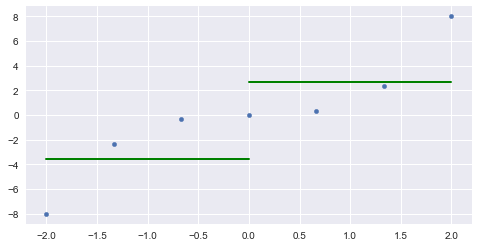

In [4]:
# Ваш код здесь
tree1 = DecisionTreeRegressor(max_depth=0.1)
tree1.fit(X[X < 0].reshape(len(X[X < 0]), 1), y[X < 0])
pred1 = tree1.predict(np.linspace(-2, 2, 7).reshape(7, 1))

tree2 = DecisionTreeRegressor(max_depth=0.1)
tree2.fit(X[X >= 0].reshape(len(X[X >= 0]), 1), y[X >= 0])
pred2 = tree2.predict(np.linspace(-2, 2, 7).reshape(7, 1))

plt.figure(figsize=(8, 4))
#plt.plot(X, y, "b")
plt.scatter(X, y, s=20)
plt.plot(np.linspace(-2, 0, 7), pred1, "g", lw=2)
plt.plot(np.linspace(0, 2, 7), pred2, "g", lw=2)
plt.show()

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [5]:
def regression_var_criterion(X, y, t):
    n = len(X)
    m = y.mean()
    d = np.mean((y - m)**2)
    ind_left = X < t
    ind_right = ~ind_left
    n_left = sum(ind_left)
    m_left = y[ind_left].mean()
    d_left = np.mean((y[ind_left] - m_left)**2)
    n_right = sum(ind_right)
    m_right = y[ind_right].mean()
    d_right = np.mean((y[ind_right] - m_right)**2)
    return d - n_left * 1.0 / n * d_left - n_right * 1.0 / n * d_right

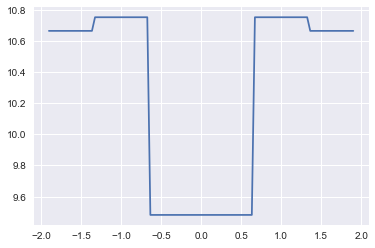

In [6]:
# Ваш код здесь
plt.plot(np.linspace(-1.9, 1.9, 100), [regression_var_criterion(X, y, e) for e in np.linspace(-1.9, 1.9, 100)])

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

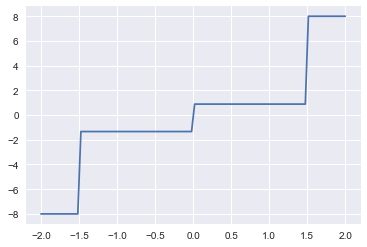

In [7]:
# Ваш код здесь
def my_predict(x, X, y):
    if x < 0:
        if x < -1.5:
            return y[(X < 0) & (X < -1.5)].mean()
        else:
            return y[(X < 0) & (X >= -1.5)].mean()
    else:
        if x < 1.5:
            return y[(X >= 0) & (X < 1.5)].mean()
        else:
            return y[(X >= 0) & (X >= 1.5)].mean()

plt.plot(np.linspace(-2, 2, 100), [my_predict(e, X, y) for e in np.linspace(-2, 2, 100)])

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [8]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [9]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [10]:
# Ваш код здесь
df['age_years'] = df['age'] / 365.25

In [11]:
df = pd.concat([df,
                pd.get_dummies(df['cholesterol'], prefix='cholesterol'),
                pd.get_dummies(df['gluc'], prefix='gluc')], axis=1)

In [12]:
df

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.357290,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.381246,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.627652,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.249144,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.841205,1,0,0,1,0,0
8,21914,1,151,67.0,120,80,2,2,0,0,0,0,59.997262,0,1,0,0,1,0
9,22113,1,157,93.0,130,80,3,1,0,0,1,0,60.542094,0,0,1,1,0,0
12,22584,2,178,95.0,130,90,3,3,0,0,1,1,61.831622,0,0,1,0,0,1
13,17668,1,158,71.0,110,70,1,1,0,0,1,0,48.372348,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(df.loc[:, df.columns != 'cardio'], 
                                                      df['cardio'], train_size=0.7, random_state=17) # Ваш код здесь

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [14]:
def get_code(tree, feature_names, target_names,
             spacer_base="    "):
    """Produce psuedo-code for decision tree.

    Args
    ----
    tree -- scikit-leant DescisionTree.
    feature_names -- list of feature names.
    target_names -- list of target (class) names.
    spacer_base -- used for spacing code (default: "    ").

    Notes
    -----
    based on http://stackoverflow.com/a/30104792.
    """
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth):
        spacer = spacer_base * depth
        if (threshold[node] != -2):
            print(spacer + "if ( " + features[node] + " <= " + \
                  str(threshold[node]) + " ) {")
            if left[node] != -1:
                    recurse(left, right, threshold, features,
                            left[node], depth+1)
            print(spacer + "\n" + spacer +"} else {")
            if right[node] != -1:
                    recurse(left, right, threshold, features,
                            right[node], depth+1)
            print("\n" + spacer + "}", end = "")
        else:
            target = value[node]
            for i, v in zip(np.nonzero(target)[1],
                            target[np.nonzero(target)]):
                target_name = target_names[i]
                target_count = int(v)
                print(spacer + "return " + str(target_name) + \
                      " ( weight = " + str(v) + " )", end = "")
                if i + 1 != len(np.nonzero(target)[1]):
                    print()
    recurse(left, right, threshold, features, 0, 0)       

In [15]:
# Ваш код здесь
tree0 = DecisionTreeClassifier(max_depth=3, random_state=17)
tree0.fit(X_train, y_train)
print(list(zip(tree0.feature_importances_, X_train.columns)))
print()
get_code(tree0, X_train.columns, [0, 1])

[(0.0979852655593451, 'age'), (0.0, 'gender'), (0.0, 'height'), (0.0, 'weight'), (0.82632433069188882, 'ap_hi'), (0.0, 'ap_lo'), (0.0, 'cholesterol'), (0.0, 'gluc'), (0.0, 'smoke'), (0.0, 'alco'), (0.0, 'active'), (0.0, 'age_years'), (0.0, 'cholesterol_1'), (0.0, 'cholesterol_2'), (0.075690403748766094, 'cholesterol_3'), (0.0, 'gluc_1'), (0.0, 'gluc_2'), (0.0, 'gluc_3')]

if ( ap_hi <= 129.5 ) {
    if ( age <= 19931.5 ) {
        if ( cholesterol_3 <= 0.5 ) {
            return 0 ( weight = 13235.0 )
            return 1 ( weight = 3733.0 )        
        } else {
            return 0 ( weight = 320.0 )
            return 1 ( weight = 427.0 )
        }    
    } else {
        if ( cholesterol_3 <= 0.5 ) {
            return 0 ( weight = 5865.0 )
            return 1 ( weight = 4178.0 )        
        } else {
            return 0 ( weight = 338.0 )
            return 1 ( weight = 829.0 )
        }
    }
} else {
    if ( ap_hi <= 138.5 ) {
        if ( cholesterol_3 <= 0.5 ) {
    

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [17]:
# Ваш код здесь
accuracy_score(y_valid, tree0.predict(X_valid))

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [18]:
# Ваш код здесь
from sklearn.metrics import make_scorer
acc_scorer = make_scorer(accuracy_score)

tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree_params = {'max_depth': list(range(2, 11))}
tree_grid = GridSearchCV(tree, param_grid=tree_params, cv=5, scoring=acc_scorer)
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=17, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(accuracy_score), verbose=0)

In [19]:
tree_grid.cv_results_

{'mean_fit_time': array([ 0.04872937,  0.0590692 ,  0.07669945,  0.07991242,  0.09024596,
         0.10337915,  0.11219854,  0.12031956,  0.1293612 ]),
 'mean_score_time': array([ 0.00150461,  0.00170455,  0.00221081,  0.00191059,  0.00180459,
         0.00170441,  0.00181022,  0.00190563,  0.00229926]),
 'mean_test_score': array([ 0.7155102 ,  0.72771429,  0.7304898 ,  0.73095918,  0.73197959,
         0.73046939,  0.72971429,  0.72789796,  0.72604082]),
 'mean_train_score': array([ 0.71551022,  0.7277143 ,  0.7307194 ,  0.73351022,  0.73529084,
         0.73989288,  0.7449337 ,  0.75080615,  0.75804593]),
 'param_max_depth': masked_array(data = [2 3 4 5 6 7 8 9 10],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': ({'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9},
  {'max_depth': 10}),
 'rank_test_score': array([9

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

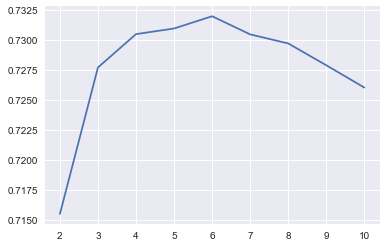

In [20]:
# Ваш код здесь
plt.plot(list(range(2, 11)), tree_grid.cv_results_['mean_test_score'])

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [21]:
# Ваш код здесь
c1 = accuracy_score(y_valid, tree_grid.predict(X_valid))
c2 = accuracy_score(y_valid, tree0.predict(X_valid))
print(c1, c2, (c2 - c1) / c1)

0.725857142857 0.721285714286 -0.00629797283999


**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- да, нет
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [26]:
# Ваш код здесь
df['age_45_50'] = ((df['age_years'] >= 45) & (df['age_years'] < 50)).apply(int)
df['age_50_55'] = ((df['age_years'] >= 50) & (df['age_years'] < 55)).apply(int)
df['age_55_60'] = ((df['age_years'] >= 55) & (df['age_years'] < 60)).apply(int)
df['age_60_65'] = ((df['age_years'] >= 60) & (df['age_years'] < 65)).apply(int)

df['ap_hi_120_140'] = ((df['ap_hi'] >= 120) & (df['ap_hi'] < 140)).apply(int)
df['ap_hi_140_160'] = ((df['ap_hi'] >= 140) & (df['ap_hi'] < 160)).apply(int)
df['ap_hi_160_180'] = ((df['ap_hi'] >= 160) & (df['ap_hi'] < 180)).apply(int)

df['male'] = df['gender'] - 1

features = ['age_45_50', 'age_50_55', 'age_55_60', 'age_60_65']
features += ['ap_hi_120_140', 'ap_hi_140_160', 'ap_hi_160_180']
features += ['cholesterol_1', 'cholesterol_2', 'cholesterol_3']
features += ['male', 'smoke']

from IPython.display import display
#display(df[features])

print(len(features))
tree5 =DecisionTreeClassifier(max_depth=3, random_state=17)
tree5.fit(df[features], df['cardio'])
get_code(tree5, features, [0, 1])

12
if ( ap_hi_140_160 <= 0.5 ) {
    if ( ap_hi_160_180 <= 0.5 ) {
        if ( cholesterol_3 <= 0.5 ) {
            return 0 ( weight = 30688.0 )
            return 1 ( weight = 16289.0 )        
        } else {
            return 0 ( weight = 1335.0 )
            return 1 ( weight = 3351.0 )
        }    
    } else {
        if ( smoke <= 0.5 ) {
            return 0 ( weight = 489.0 )
            return 1 ( weight = 3025.0 )        
        } else {
            return 0 ( weight = 45.0 )
            return 1 ( weight = 342.0 )
        }
    }
} else {
    if ( age_55_60 <= 0.5 ) {
        if ( age_50_55 <= 0.5 ) {
            return 0 ( weight = 1065.0 )
            return 1 ( weight = 5721.0 )        
        } else {
            return 0 ( weight = 592.0 )
            return 1 ( weight = 2749.0 )
        }    
    } else {
        if ( cholesterol_1 <= 0.5 ) {
            return 0 ( weight = 282.0 )
            return 1 ( weight = 1438.0 )        
        } else {
            re